In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import numpy, os, pandas 

In [3]:
import tensorflow

In [4]:
# tensorflow.enable_eager_execution()

In [5]:
from tensorflow import keras

In [6]:
print(tensorflow.__version__)

1.11.0


In [7]:
df = pandas.read_excel('../data/AmesHousing.xls')
df.head(10)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500
6,7,527127150,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,213500
7,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500
8,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,236500
9,10,527162130,60,RL,60.0,7500,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,189000


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
column_names = ['Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add' ]

In [10]:
data = df[ column_names ]
labels = df.SalePrice

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

In [12]:
print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (2344, 4)
Testing set:  (586, 4)


In [13]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
# Test data is *not* used when calculating the mean and std

train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

In [14]:
df = pandas.DataFrame(train_data, columns=column_names)
df.head()

,Overall Qual,Overall Cond,Year Built,Year Remod/Add
727,-2.194356,-2.306961,-2.355085,-1.658808
978,-1.484212,0.396347,-0.039640,1.142766
647,-0.774069,0.396347,-0.866585,-1.658808
1593,-0.774069,0.396347,0.125749,-0.451233
2705,-1.484212,-0.504756,-0.271184,-0.258021


### Model building

In [91]:
def build_model(units=64):
    model = keras.Sequential( [
        keras.layers.Dense( units, kernel_regularizer=keras.regularizers.l2(0.001), 
                           activation=tensorflow.nn.relu, input_shape=(train_data.shape[1],) ),
                
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense( units, kernel_regularizer=keras.regularizers.l2(0.001), 
                           activation=tensorflow.nn.relu ),
        
        keras.layers.Dropout(0.2),
        
        keras.layers.Dense(1, activation=tensorflow.nn.sigmoid)
      ] )
    
    optimizer = tensorflow.train.RMSPropOptimizer(0.001)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    
    return model

### Train a model

In [17]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [18]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [22]:
def get_cp_callback(checkpoint):
    # include the epoch in the file name. (uses `str.format`)
    checkpoint_path = "../training_1/" + checkpoint + "-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create checkpoint callback
    cp_callback = tensorflow.keras.callbacks.ModelCheckpoint( checkpoint_dir, verbose=0, save_weights_only=True ) 
    # Save weights, every 5-epochs.
    # ,period=5)
    
    return cp_callback

In [44]:
def train_model(model, train_data, train_labels, EPOCHS=50, callbacks = [] ) :    
    # callbacks=[ cp_callback, early_stop, PrintDot() ]
    callbacks.extend( [ early_stop, PrintDot() ] )
    
    # Store training stats
    history = model.fit( train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks = callbacks )
    
    return history, model

In [64]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [65]:
history, model = train_model( model, train_data, train_labels )


.
.
.
.
.
.......................................................................................................................................................................................................................................................................................................

### Plot

In [53]:
from matplotlib import pyplot

In [54]:
def plot_history(history):
    pyplot.figure()
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Mean Abs Error [1000$]')
  
    pyplot.plot(history.epoch, numpy.array(history.history['mean_absolute_error']), label='Train Loss')
    pyplot.plot(history.epoch, numpy.array(history.history['val_mean_absolute_error']), label = 'Val loss')
    
    pyplot.legend()
    # pyplot.ylim([0, 5])

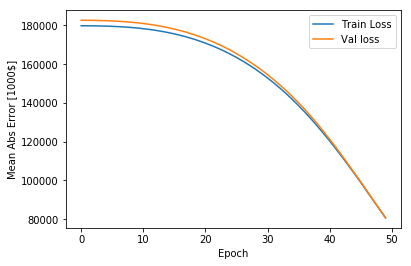

In [66]:
plot_history(history)

In [ ]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

In [69]:
def plot_predict(test_labels, test_predictions):
    pyplot.scatter(test_labels, test_predictions)
    
    pyplot.xlabel('True Values [1000$]')
    pyplot.ylabel('Predictions [1000$]')
    
    pyplot.axis('equal')
    
    pyplot.xlim(pyplot.xlim())
    pyplot.ylim(pyplot.ylim())
    
    _ = pyplot.plot([-100, 100], [-100, 100])

In [ ]:
test_predictions = model.predict(test_data).flatten()

In [ ]:
plot_predict(test_labels, test_predictions)

In [70]:
def plot_predict_error(test_labels, test_predictions):
    error = test_predictions - test_labels
    
    pyplot.hist(error, bins = 50)
    
    pyplot.xlabel("Prediction Error [1000$]")
    _ = pyplot.ylabel("Count")

In [ ]:
plot_predict_error(test_labels, test_predictions)

In [67]:
def plot_compare_history(histories, key='mean_absolute_error'):
    pyplot.figure(figsize=(16,10))
    
    for name, history in histories:
        val = pyplot.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
                
        pyplot.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    pyplot.xlabel('Epochs')
    pyplot.ylabel(key.replace('_',' ').title())
    pyplot.legend()

    # pyplot.xlim([0,max(history.epoch)])

### Experiment Overfitting

In [63]:
model_64 = build_model(64)
history_64, model_64 = train_model( model_64, train_data, train_labels )
model_64.summary()


.
.
.
.
......................................................................................................................................................................................................................................................_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [46]:
model_16 = build_model(16)
history_16, model_16 = train_model( model_16, train_data, train_labels )
model_16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


In [49]:
model_512 = build_model(512)
history_512, model_512 = train_model( model_512, train_data, train_labels )
model_512.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               2560      
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 265,729
Trainable params: 265,729
Non-trainable params: 0
_________________________________________________________________


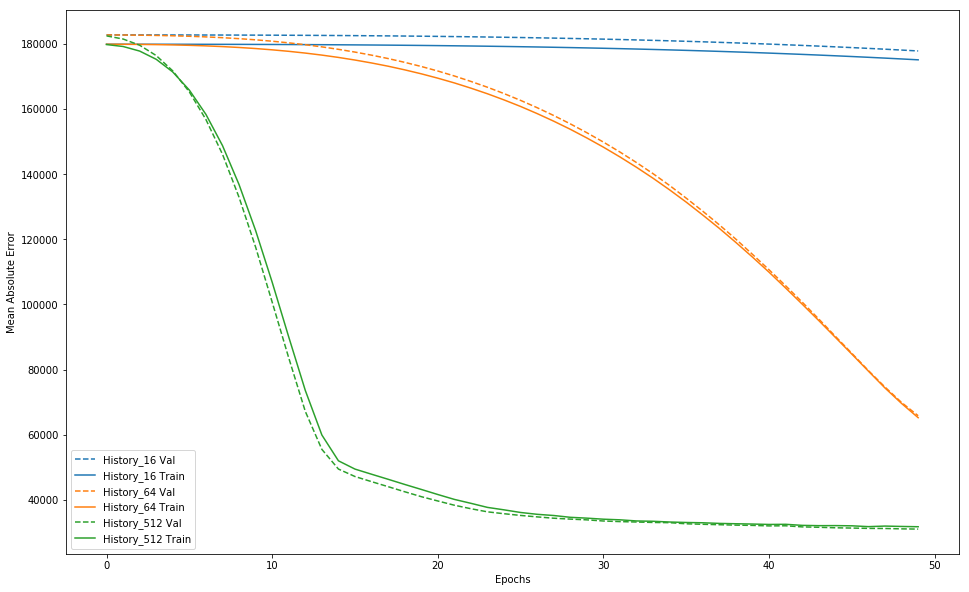

In [68]:
plot_compare_history( [
    ('history_16', history_16 ),
    ('history_64', history_64 ),
    ('history_512', history_512 )
] )

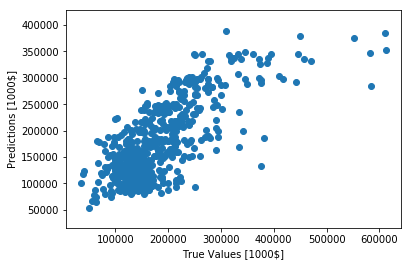

In [94]:
test_predictions = model_l2.predict(test_data).flatten()
plot_predict(test_labels, test_predictions)

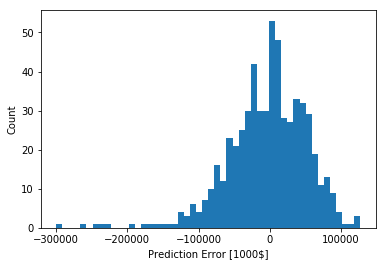

In [95]:
plot_predict_error(test_labels, test_predictions)

In [92]:
model_l2 = build_model(128)
history_l2, model_l2 = train_model( model_l2, train_data, train_labels )
model_l2.summary()


.
.
.
.
.
.
.
.
.
.
.
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................._________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 128)               640       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________________________________________________________

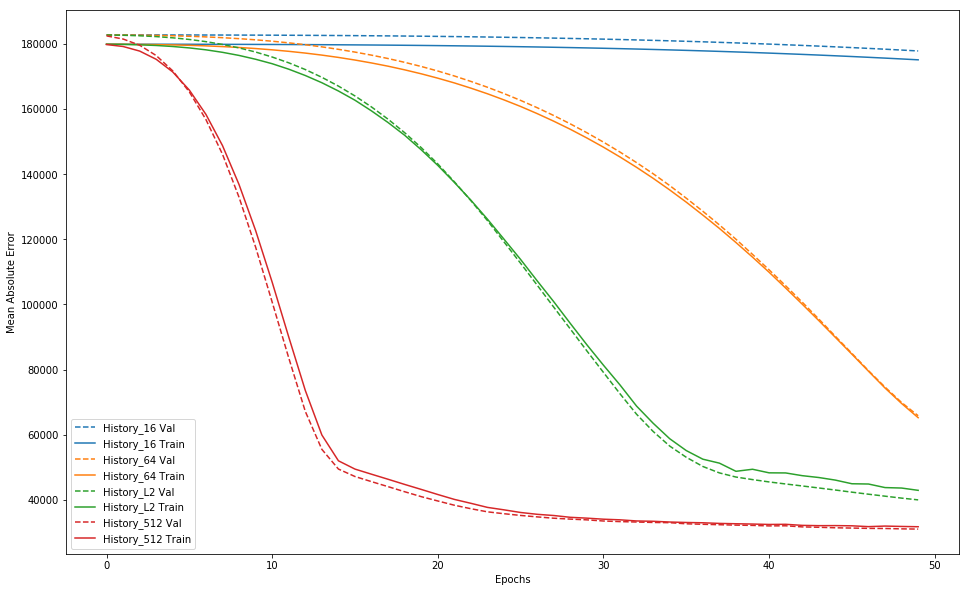

In [93]:
plot_compare_history( [
    ('history_16', history_16 ),
    ('history_64', history_64 ),
    ('history_l2', history_l2 ),
    ('history_512', history_512 )
] )

### Manually save weights

In [99]:
# create a new model
model_l2 = build_model(128)
history_l2, model_l2 = train_model( model_l2, train_data, train_labels )
model_l2.summary()


checkpoint_path = "../training_1/"
checkpoint_dir = checkpoint_path + "my_checkpoint"

loss, acc = model_l2.evaluate( train_data, train_labels )
print("Trained model, accuracy: {:5.2f}%".format(100*acc))

# Save the weights
model_l2.save_weights( checkpoint_dir )

# # load the latest weight
latest = tensorflow.train.latest_checkpoint( checkpoint_path )
print( latest )

# Restore the weights
model_l2 = build_model(128)
# # restore latest weight from file
model_l2.load_weights(latest)

loss,acc = model.evaluate( train_data, train_labels )
print("Restored model, accuracy: {:5.2f}%".format(100*acc))


.
.
.
.
.
.
.
.
.
.
.
.
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................._________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 128)               640       
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_______